In [94]:
import numpy as np
import torch
import torchvision
import torchmetrics
import lightning.pytorch as pl 
from torchinfo import summary 
from torchview import draw_graph 
import matplotlib.pyplot as plt 
import pandas as pd

if (torch.cuda.is_available()): 
    device = ("cuda")
else:
    device = ("cpu")
print(f"Use GPU: {torch.cuda.is_available()}")

Use GPU: False


In [95]:
# Config Section

cfg_data_folder = "datasets/cifar10"
# cfg_log_folder = "logs"
# cfg_log_version = "cifar10"

cfg_max_epochs = 10;

cfg_cifar10_labels = {
  0: "Airplane",
  1: "Automobile",
  2: "Bird",
  3: "Cat",
  4: "Deer",
  5: "Dog",
  6: "Frog",
  7: "Horse",
  8: "Ship",
  9: "Truck",
}

cfg_num_workers = 5


In [96]:
# Load the data set and scale to [-1,+1]
training_dataset = torchvision.datasets.CIFAR10(root=cfg_data_folder, download=True, train=True)
testing_dataset = torchvision.datasets.CIFAR10(root=cfg_data_folder,  download=True, train=False) 

x_train = (torch.Tensor(training_dataset.data) / 127.5) - 1.0
y_train = torch.Tensor(training_dataset.targets).to(torch.long)
x_test = (torch.Tensor(testing_dataset.data) / 127.5) - 1.0 
y_test = torch.Tensor(testing_dataset.targets).to(torch.long)

# You can set a seed value here if you
# want to control the shuffling process...
rng = np.random.default_rng()
permutation = rng.permutation(x_train.shape[0]) 
split_point = int(x_train.shape[0] * 0.8) # 80%/20% split

# Split into validation/training - keep test # set aside for later...
x_val = x_train[permutation][split_point:]
y_val = y_train[permutation][split_point:]
x_train = x_train[permutation][:split_point]
y_train = y_train[permutation][:split_point]

print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

Files already downloaded and verified
Files already downloaded and verified
torch.Size([40000, 32, 32, 3])
torch.Size([10000, 32, 32, 3])
torch.Size([10000, 32, 32, 3])


In [97]:
x_train.shape

torch.Size([40000, 32, 32, 3])

In [98]:
# Show how many labels.
y_train.shape

torch.Size([40000])

In [99]:
# Show the Classes
np.unique(y_train)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

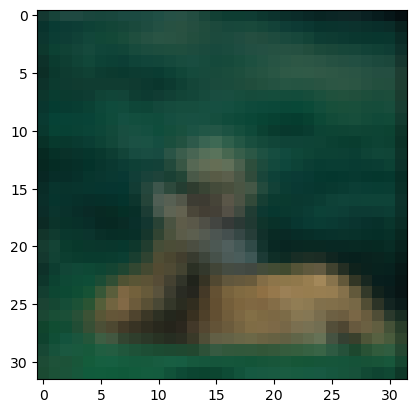

Label: Deer (idx: 4)


In [100]:
plt.imshow((x_train[0].detach().numpy() + 1.0)/2.0)
plt.show()
print(f"Label: {cfg_cifar10_labels.get(int(y_train[0]))} (idx: {y_train[0]})")

In [101]:
x_train.shape[1:].numel()

3072

In [102]:
class SingleLayerNetwork(torch.nn.Module): 
    def __init__(self, input_size, output_size, **kwargs):
        super().__init__(**kwargs)
        self.flatten_layer = torch.nn.Flatten() 
        self.output_layer = torch.nn.Linear(input_size.numel(), output_size)
                                            
    def forward(self, x):
        y = x
        y = self.flatten_layer(y) 
        y = self.output_layer(y) 
        return y
    
    def predict(self, x): 
        y = x
        y = self.forward(y)
        y = torch.softmax(y, -1) 
        return y
    
        
# Define Trainable Module
class PLModel(pl.LightningModule):
    def __init__(self, module, **kwargs):
        # This is the contructor, where we typically make
        # layer objects using provided arguments. 
        super().__init__(**kwargs) # Call the super class constructor 
        self.module = module
        
        # This creates an accuracy function
        self.model_acc = torchmetrics.classification.Accuracy(task='multiclass', 
                                                              num_classes=module.output_layer.out_features)
        # This creates a loss function
        self.model_loss = torch.nn.CrossEntropyLoss()
    
    def forward(self, x):
        return self.module.forward(x) 
        
    def predict(self, x):
        return self.module.predict(x)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.001)
        return optimizer

    def training_step(self, train_batch, batch_idx): 
        x, y_true = train_batch
        y_pred = self(x)
        acc = self.model_acc(y_pred, y_true)
        loss = self.model_loss(y_pred, y_true) 
        self.log('train_acc',  acc,  on_step=False, on_epoch=True)
        self.log('train_loss', loss, on_step=False, on_epoch=True) 
        return loss


    def validation_step(self, val_batch, batch_idx): 
        x, y_true = val_batch
        y_pred = self(x)
        acc = self.model_acc(y_pred, y_true)
        loss = self.model_loss(y_pred, y_true)
        self.log('val_acc',  acc,  on_step=False, on_epoch=True)
        self.log('val_loss', loss, on_step=False, on_epoch=True)
        return loss
        
    def test_step(self, test_batch, batch_idx):
        x, y_true = test_batch
        y_pred = self(x)
        acc = self.model_acc(y_pred,y_true)
        loss = self.model_loss(y_pred,y_true)
        self.log('test_acc',  acc,  on_step=False, on_epoch=True)
        self.log('test_loss', loss, on_step=False, on_epoch=True)
        return loss


In [103]:
model = PLModel(SingleLayerNetwork(x_train.shape[1:],
                                   len(y_train.unique())))

In [104]:
summary(model, input_size=(1,) + x_train.shape[1:])

Layer (type:depth-idx)                   Output Shape              Param #
PLModel                                  [1, 10]                   --
├─SingleLayerNetwork: 1-1                --                        --
│    └─Flatten: 2-1                      [1, 3072]                 --
│    └─Linear: 2-2                       [1, 10]                   30,730
Total params: 30,730
Trainable params: 30,730
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.03
Input size (MB): 0.01
Forward/backward pass size (MB): 0.00
Params size (MB): 0.12
Estimated Total Size (MB): 0.14

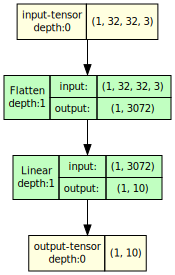

In [105]:
model_graph = draw_graph(model, 
                         input_size=(1,) + x_train.shape[1:],
                         device=device,
                         depth=1)
model_graph.visual_graph

In [106]:
predictions = model.predict(x_train[:5].to(device)).cpu().detach().numpy()

predictions

array([[0.11830413, 0.0667785 , 0.14465289, 0.04259076, 0.12037615,
        0.10060684, 0.09392061, 0.09323096, 0.08100898, 0.1385302 ],
       [0.10154311, 0.10068988, 0.11253892, 0.09420252, 0.09089354,
        0.10924298, 0.09480107, 0.10760137, 0.08730025, 0.10118632],
       [0.10427747, 0.08107223, 0.11065746, 0.06155414, 0.1459464 ,
        0.09793883, 0.08415545, 0.12798244, 0.07458452, 0.11183113],
       [0.10198316, 0.06925185, 0.12911758, 0.07520712, 0.09749453,
        0.10436971, 0.07836039, 0.11293925, 0.11257373, 0.1187028 ],
       [0.10970342, 0.07983243, 0.11532923, 0.06041475, 0.1628578 ,
        0.09195222, 0.08658307, 0.09453807, 0.08692213, 0.11186697]],
      dtype=float32)

In [107]:
predictions.shape

(5, 10)

In [108]:
predictions.argmax(-1)

array([2, 2, 4, 2, 4])

In [109]:
y_train[:5]

tensor([4, 3, 9, 9, 5])

In [110]:
model.model_loss(model(x_train[:5].to(device)),
                 y_train[:5].to(device)
                ).cpu().detach().numpy()

array(2.2375653, dtype=float32)

In [111]:
model.model_acc(model(x_train[:5].to(device)),
                y_train[:5].to(device)).cpu().detach().numpy()

array(0., dtype=float32)

In [112]:
xy_train = torch.utils.data.DataLoader(list(zip(x_train, y_train)),
                                       shuffle=True,
                                       batch_size=250,
                                       num_workers=cfg_num_workers) # Using CFG

xy_val = torch.utils.data.DataLoader(list(zip(x_val, y_val)),
                                     shuffle=False,
                                     batch_size=250,
                                     num_workers=cfg_num_workers) # Using CFG

xy_test = torch.utils.data.DataLoader(list(zip(x_test, y_test)),
                                      shuffle=False,
                                      batch_size=250,
                                      num_workers=cfg_num_workers) # Using CFG

In [113]:
# Setup Logger
logger = pl.loggers.CSVLogger("logs", name="OL2", version="single")

In [114]:
trainer = pl.Trainer(logger=logger,
                     max_epochs=cfg_max_epochs,
                     enable_progress_bar=True,
                     log_every_n_steps=0,
                     callbacks=[pl.callbacks.TQDMProgressBar(refresh_rate=20)])

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [115]:
trainer.validate(model, xy_val)

Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃  Runningstage.validating  ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.11590000241994858    │
│         val_loss          │     2.319303274154663     │
└───────────────────────────┴───────────────────────────┘

[{'val_acc': 0.11590000241994858, 'val_loss': 2.319303274154663}]

In [116]:
# Train Model -  This takes awhile!!!
trainer.fit(model, xy_train, xy_val)


  | Name       | Type               | Params
--------------------------------------------------
0 | module     | SingleLayerNetwork | 30.7 K
1 | model_acc  | MulticlassAccuracy | 0     
2 | model_loss | CrossEntropyLoss   | 0     
--------------------------------------------------
30.7 K    Trainable params
0         Non-trainable params
30.7 K    Total params
0.123     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


In [117]:
# Validate on Model
trainer.validate(model, xy_val)

Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃  Runningstage.validating  ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.40059998631477356    │
│         val_loss          │    1.7664916515350342     │
└───────────────────────────┴───────────────────────────┘

[{'val_acc': 0.40059998631477356, 'val_loss': 1.7664916515350342}]

In [118]:
results = pd.read_csv(logger.log_dir+"/metrics.csv")
results

,val_acc,val_loss,epoch,step,train_acc,train_loss
0,0.1159,2.319303,0,0,NaN,NaN
1,0.3947,1.764272,0,159,NaN,NaN
2,NaN,NaN,0,159,0.362325,1.848774
3,0.4104,1.740899,1,319,NaN,NaN
4,NaN,NaN,1,319,0.395525,1.758327
5,0.3850,1.785881,2,479,NaN,NaN
6,NaN,NaN,2,479,0.406600,1.732024
7,0.4058,1.737526,3,639,NaN,NaN
8,NaN,NaN,3,639,0.412050,1.718203
9,0.4066,1.735922,4,799,NaN,NaN


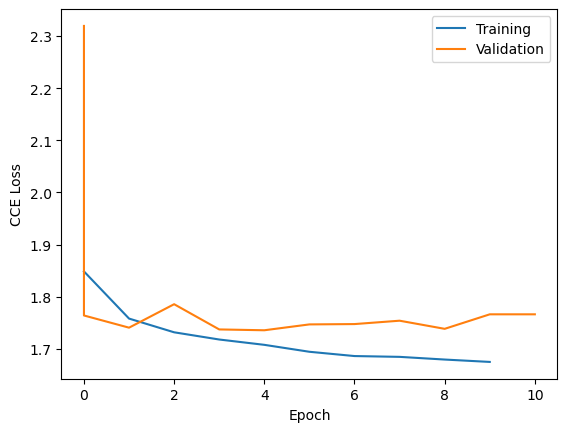

In [119]:
plt.plot(results["epoch"][np.logical_not(np.isnan(results["train_loss"]))],
         results["train_loss"][np.logical_not(np.isnan(results["train_loss"]))],
         label="Training")

plt.plot(results["epoch"][np.logical_not(np.isnan(results["val_loss"]))],
         results["val_loss"][np.logical_not(np.isnan(results["val_loss"]))],
         label="Validation")

plt.legend()
plt.ylabel("CCE Loss")
plt.xlabel("Epoch")
plt.show()


In [120]:
print("Validation accuracy:",*["%.8f"%(x) for x in results['val_acc'][np.logical_not(np.isnan(results["val_acc"]))]])

Validation accuracy: 0.11590000 0.39469999 0.41040000 0.38499999 0.40580001 0.40660000 0.40400001 0.40340000 0.40070000 0.40759999 0.40059999 0.40059999


In [121]:
print("Testing accuracy:", trainer.test(model, xy_test)[0]['test_acc'])

Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.3813999891281128     │
│         test_loss         │    1.7842605113983154     │
└───────────────────────────┴───────────────────────────┘

Testing accuracy: 0.3813999891281128
